# Applications of Gradient Boosting

This notebook requires `hep_ml`. If you're not using cloud, use 
```
!pip install hep_ml
```

## Reweighting of distributions with Boosted Decision Trees

Initially you have two distributions: sample_original, sample_target. 

You need to reweight a distribution, that is assign new weights to the original distribution so that there is no difference between sample_original (with new weights) and sample_target.

 - reweighting in physics (correction of Monte Carlo simulation)
 - reweighting in surveying (correction for non-response bias)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

//anaconda/envs/py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load the data
Dataset is anonymized, so no names of features.
In HEP terms, an original distibution is simulation, a target distribution is Real Data


In [2]:
original = pandas.read_csv('datasets/original.csv')
target = pandas.read_csv('datasets/target.csv')

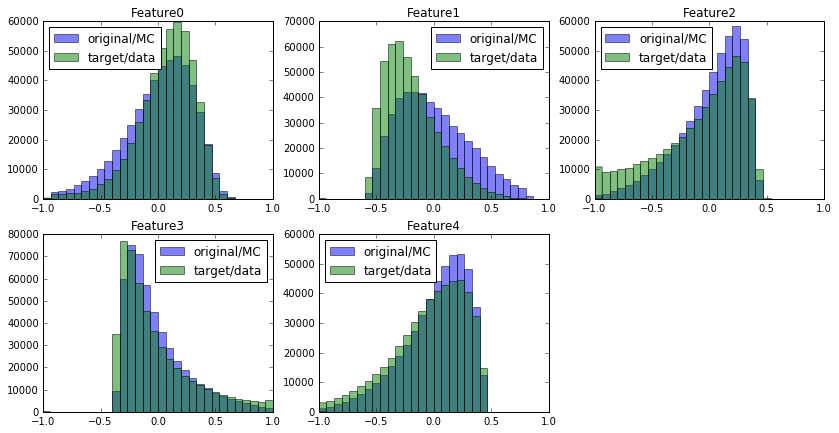

In [3]:
plt.figure(figsize=[14, 7])
for i, column in enumerate(original.columns, start=1):
    plt.subplot(2, 3, i)
    plt.title(column)
    plt.hist(original[column], range=[-1, 1], bins=30, alpha=0.5, label='original/MC')
    plt.hist(target[column],   range=[-1, 1], bins=30, alpha=0.5, label='target/data')
    plt.legend(loc='best')

## Comparison of multidimensional distributions

When you need to say, whether two samples have the same distribution, you have the options:

- simple and wrong: look at 1-dimensional distributions
- good and complex: find out, whether a classification model is able to find the difference between two distributions. <br />
  As usual, we train on the part of the data and then check the quality on a holdout. Let's see:

In [4]:
train_original, test_original = train_test_split(original, train_size=0.4, random_state=42)
train_target,   test_target   = train_test_split(target, train_size=0.4, random_state=42)

In [5]:
# using the default parameters, 
# BUT in practice you should take parameters of classification model used in your analysis
clf = GradientBoostingClassifier()
trainX = numpy.vstack([train_original, train_target])
trainY = [0] * len(train_original) + [1] * len(train_target)
clf.fit(trainX, trainY)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [6]:
testX = numpy.vstack([test_original, test_target])
testY = [0] * len(test_original) + [1] * len(test_target)
test_proba = clf.predict_proba(testX)
train_proba = clf.predict_proba(trainX)

## Checking the discrimination using ROC

pay attention - we used train/test splitting. We see that there is a large difference between the distributions, and a classification model easily found it:

ROC AUC 0.745808225922


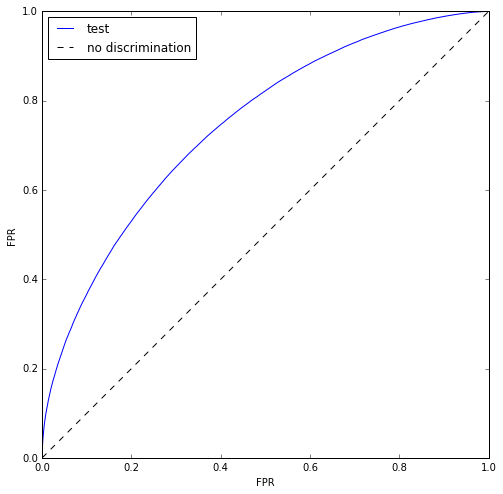

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(testY,  test_proba[:, 1])[:2],  label='test')
plt.plot([0, 1], [0, 1], 'k--', label='no discrimination')
plt.xlabel('FPR'), plt.ylabel('FPR')
plt.legend(loc='best')

print 'ROC AUC', roc_auc_score(testY,  test_proba[:, 1])

## Function for minimal testing of reweighing

In [8]:
# we prepared a special function for testing reweighting
# it plots 1d feature distributions for reweighted original samples and target samples 
#    and roc curve (how a classifier can distinguish reweighted original samples and target samples)
# pay attention - you should use train_original, train_target to train a reweighter 
def check_discrimination(new_test_original_weights):
    new_test_original_weights = numpy.array(new_test_original_weights)
    new_test_original_weights /= 1. * numpy.mean(new_test_original_weights)
    plt.figure(figsize=[14, 7])
    for i, column in enumerate(original.columns, start=1):
        plt.subplot(2, 3, i)
        plt.title(column)
        plt.hist(test_original[column], range=[-1, 1], bins=30, alpha=0.5, normed=True,
                 weights=new_test_original_weights, label='original/MC')
        plt.hist(test_target[column],   range=[-1, 1], bins=30, alpha=0.5, normed=True, label='target/data')
        plt.legend(loc='best')
    plt.show()

    X = numpy.vstack([test_original, test_target])
    y = [0] * len(test_original) + [1] * len(test_target)
    sample_weights = numpy.concatenate((new_test_original_weights, [1] * len(test_target)))
    
    trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, sample_weights, train_size=0.45, random_state=42)
    
    # using only 30 trees for speed 
    clf = GradientBoostingClassifier(n_estimators=30, random_state=42)
    clf.fit(trainX, trainY, sample_weight=trainW)
    test_proba = clf.predict_proba(testX)
    
    plt.figure(figsize=[8, 8])
    plt.plot(*roc_curve(testY,  test_proba[:, 1], sample_weight=testW)[:2], label='test')
    print 'ROC AUC', roc_auc_score(testY,  test_proba[:, 1], sample_weight=testW)
    plt.plot([0, 1], [0, 1], 'k--', label='no discrimination')
    plt.xlabel('FPR'), plt.ylabel('FPR')
    plt.legend(loc='best')
    plt.plot()

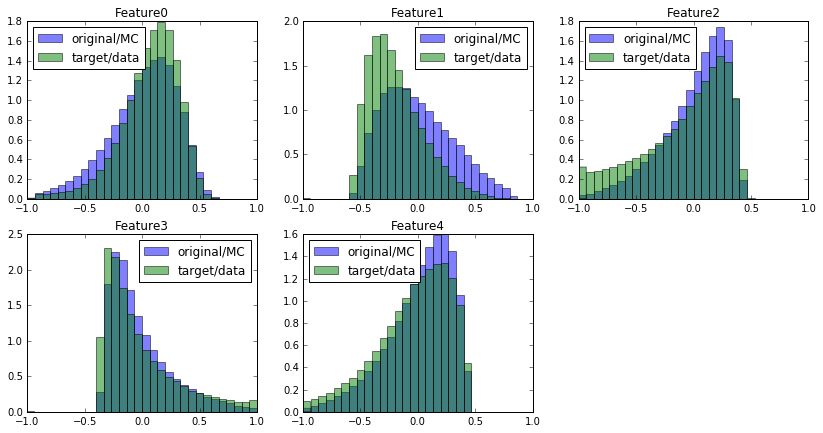

ROC AUC 0.733335473313


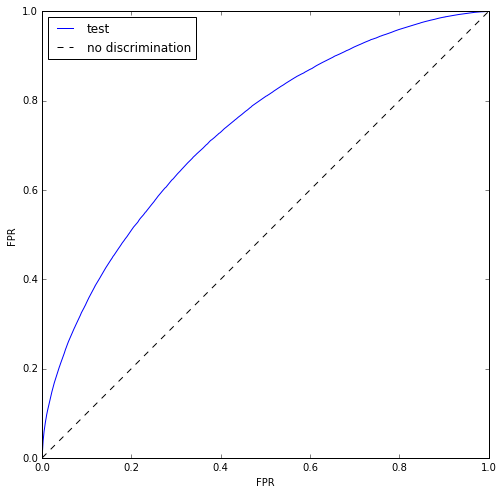

In [9]:
# for comparison: no reweighting
check_discrimination(numpy.ones(len(test_original)))

## Reweighting with bins

We train a reweighitng rule on the part of data and then check it with other part (cross-validation!).

In [10]:
feature = 'Feature0'
origin_counts, bin_limits = numpy.histogram(train_original[feature], bins=10, range=[-1, 1])
target_counts, _ = numpy.histogram(train_target[feature], bins=bin_limits)
# computing ratio in each bin
counts_ratio = target_counts * 1. /  origin_counts
# computing bin index for each sample
bin_indices = numpy.searchsorted(bin_limits[1:], test_original[feature])
# taking new weights from original weights
new_test_original_weights = counts_ratio[bin_indices]

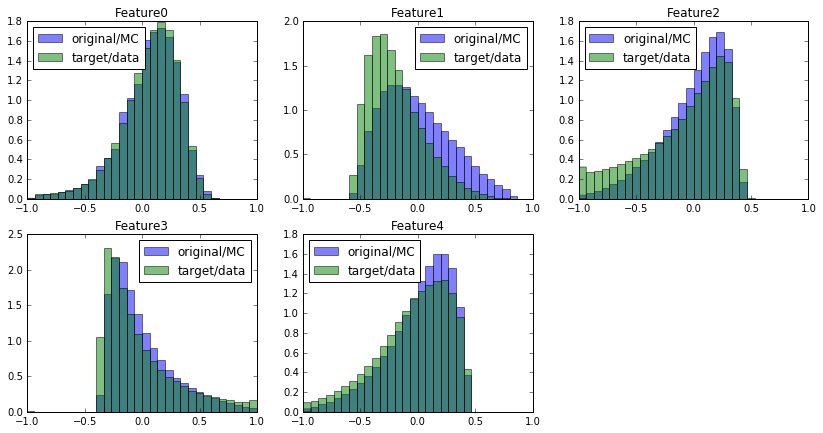

ROC AUC 0.723155639634


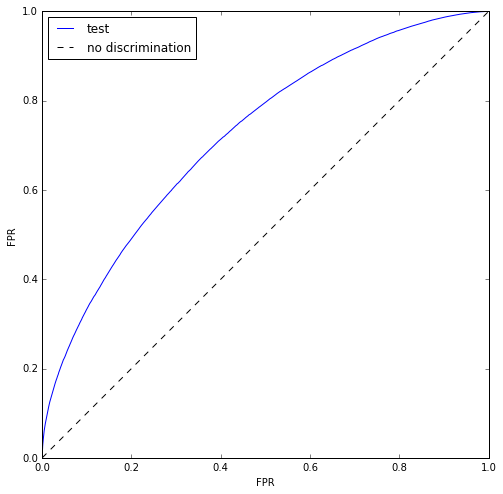

In [11]:
check_discrimination(new_test_original_weights)

## Reweighting with BDT

In [12]:
from hep_ml.reweight import GBReweighter
reweighter = GBReweighter(n_estimators=10, max_depth=2, learning_rate=0.4)
reweighter.fit(train_original, train_target)
new_bdt_test_original_weights = reweighter.predict_weights(test_original)

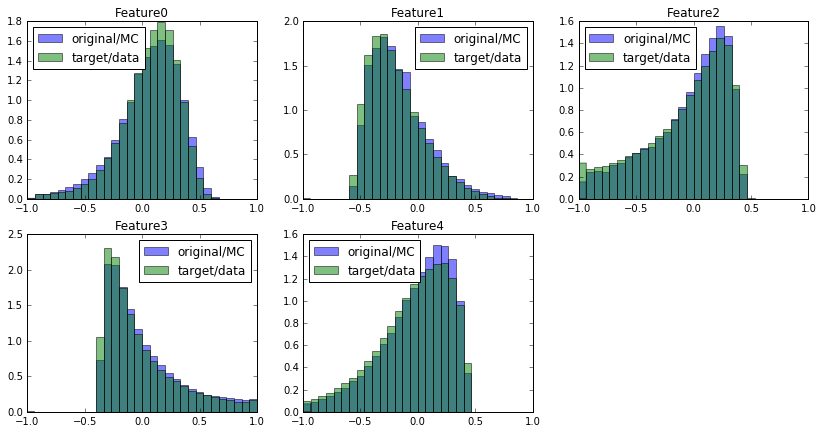

ROC AUC 0.602490565443


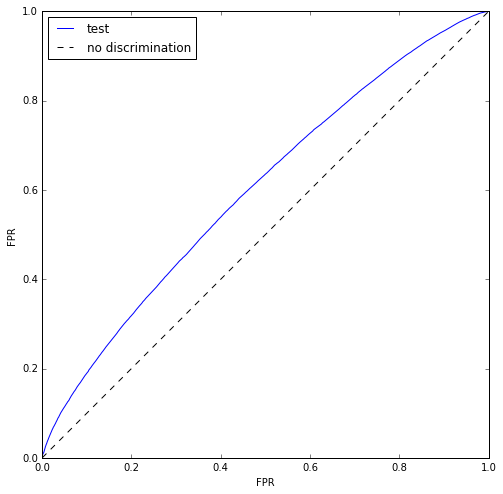

In [13]:
check_discrimination(new_bdt_test_original_weights)

To obtain the best reweighting rule we need to **minimize** the ROC AUC between reweighted original sample and target sample.


**Exercise #1.** Reweight distribution using bins. Find an optimal feature for reweighting and optimal number of bins. Use the code given above. Optionally, you can try n-dimensional reweighting with bins (use `numpy.histogram2d` or `numpy.histogramdd`). You can use `numpy.percentile` to construct percentile bin for a variable.

In [14]:
def get_discrimination_roc(new_test_original_weights):
    new_test_original_weights = numpy.array(new_test_original_weights)
    new_test_original_weights /= 1. * numpy.mean(new_test_original_weights)
    
    X = numpy.vstack([test_original, test_target])
    y = [0] * len(test_original) + [1] * len(test_target)
    sample_weights = numpy.concatenate((new_test_original_weights, [1] * len(test_target)))
    
    trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, sample_weights, train_size=0.45, random_state=42)
    
    # using only 30 trees for speed 
    clf = GradientBoostingClassifier(n_estimators=30, random_state=42)
    clf.fit(trainX, trainY, sample_weight=trainW)
    test_proba = clf.predict_proba(testX)
    
    return roc_auc_score(testY,  test_proba[:, 1], sample_weight=testW)
    

In [15]:
for feature in ['Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature4']:
    for bins in [10, 20, 40, 80, 160]:
        origin_counts, bin_limits = numpy.histogram(train_original[feature], bins=bins, range=[-1, 1])
        target_counts, _ = numpy.histogram(train_target[feature], bins=bin_limits)
        # computing ratio in each bin
        counts_ratio = target_counts * 1. /  origin_counts
        # computing bin index for each sample
        bin_indices = numpy.searchsorted(bin_limits[1:], test_original[feature])
        # taking new weights from original weights
        new_test_original_weights = counts_ratio[bin_indices]
        roc = get_discrimination_roc(new_test_original_weights)
        print "{} {} ROC {}".format(feature, bins, roc)

Feature0 10 ROC 0.723155639634
Feature0 20 ROC 0.722029527005
Feature0 40 ROC 0.722766714428
Feature0 80 ROC 0.721860633236
Feature0 160 ROC 0.722476980263
Feature1 10 ROC 0.662602555093
Feature1 20 ROC 0.663301801026
Feature1 40 ROC 0.66280303835
Feature1 80 ROC 0.662388409237
Feature1 160 ROC 0.663226598413
Feature2 10 ROC 0.71721439135
Feature2 20 ROC 0.716045067417
Feature2 40 ROC 0.715840487492
Feature2 80 ROC 0.716168473592
Feature2 160 ROC 0.715439218222
Feature3 10 ROC 0.724622016802
Feature3 20 ROC 0.72065849443
Feature3 40 ROC 0.717829273879
Feature3 80 ROC 0.717411757616
Feature3 160 ROC 0.718281074254
Feature4 10 ROC 0.72925347338
Feature4 20 ROC 0.730252040927
Feature4 40 ROC 0.730160742581
Feature4 80 ROC 0.73033882888
Feature4 160 ROC 0.729802898282


In [16]:
for feature in ['Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature4']:
    for bins in [10, 20, 40, 80, 160]:
        merged = pandas.concat([train_original[feature], train_target[feature]])
        # Так как границы данных могут расходьтся, для перцентилей используем объединение
        bin_limits = numpy.percentile(merged, numpy.linspace(0, 100, bins + 1))
        origin_counts, _ = numpy.histogram(train_original[feature], bins=bin_limits)
        target_counts, _ = numpy.histogram(train_target[feature], bins=bin_limits)
        # computing ratio in each bin
        counts_ratio = target_counts * 1. /  origin_counts
        # computing bin index for each sample
        bin_indices = numpy.searchsorted(bin_limits[1:], test_original[feature])
        # taking new weights from original weights
        new_test_original_weights = counts_ratio[bin_indices]
        roc = get_discrimination_roc(new_test_original_weights)
        print "{} {} ROC {}".format(feature, bins, roc)

Feature0 10 ROC 0.722945845454
Feature0 20 ROC 0.723126323153
Feature0 40 ROC 0.723619884744
Feature0 80 ROC 0.722526396343
Feature0 160 ROC 0.723692817085
Feature1 10 ROC 0.664525858852
Feature1 20 ROC 0.662878501867
Feature1 40 ROC 0.663330603631
Feature1 80 ROC 0.663218022029
Feature1 160 ROC 0.662653590673
Feature2 10 ROC 0.719774522073
Feature2 20 ROC 0.717289559147
Feature2 40 ROC 0.716006833131
Feature2 80 ROC 0.715922939948
Feature2 160 ROC 0.716361665128
Feature3 10 ROC 0.722933553503
Feature3 20 ROC 0.719825193273
Feature3 40 ROC 0.717871342889
Feature3 80 ROC 0.718189193099
Feature3 160 ROC 0.717993374793
Feature4 10 ROC 0.730269082849
Feature4 20 ROC 0.731003653389
Feature4 40 ROC 0.729719412332
Feature4 80 ROC 0.730405189798
Feature4 160 ROC 0.729647237415


In [17]:
def weights_for_two_features(feature1, feature2, bins):
    merged1 = pandas.concat([train_original[feature1], train_target[feature1]])
    bin_limits1 = numpy.percentile(merged1, numpy.linspace(0, 100, bins + 1))
        
    merged2 = pandas.concat([train_original[feature2], train_target[feature2]])
    bin_limits2 = numpy.percentile(merged2, numpy.linspace(0, 100, bins + 1))

    origin_counts, _, _ = numpy.histogram2d(
        train_original[feature1], 
        train_original[feature2],
        bins=[bin_limits1, bin_limits2])
    target_counts, _, _ = numpy.histogram2d(
        train_target[feature1], 
        train_original[feature2],
        bins=[bin_limits1, bin_limits2])
    # computing ratio in each bin
    counts_ratio = target_counts * 1. / origin_counts
    # computing bin index for each sample
    bin_indices1 = numpy.searchsorted(bin_limits1[1:], test_original[feature1])
    bin_indices2 = numpy.searchsorted(bin_limits2[1:], test_original[feature2])
    # taking new weights from original weights
    return counts_ratio[bin_indices1, bin_indices2]

for feature1 in ['Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature4']:
    for feature2 in ['Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature4']:
        if feature1 >= feature2:
            continue
        for bins in [5, 10, 15]:
            new_test_original_weights = weights_for_two_features(feature1, feature2, bins) 
            roc = get_discrimination_roc(new_test_original_weights)
            print "{} & {} bins {} ROC {}".format(feature1, feature2, bins, roc)

Feature0 & Feature1 bins 5 ROC 0.727679373871
Feature0 & Feature1 bins 10 ROC 0.726681366906
Feature0 & Feature1 bins 15 ROC 0.727039304077
Feature0 & Feature2 bins 5 ROC 0.722654139496
Feature0 & Feature2 bins 10 ROC 0.722116477259
Feature0 & Feature2 bins 15 ROC 0.722040598744
Feature0 & Feature3 bins 5 ROC 0.71907200229
Feature0 & Feature3 bins 10 ROC 0.717952234547
Feature0 & Feature3 bins 15 ROC 0.71761468602
Feature0 & Feature4 bins 5 ROC 0.722938147518
Feature0 & Feature4 bins 10 ROC 0.722346826504
Feature0 & Feature4 bins 15 ROC 0.722128802384
Feature1 & Feature2 bins 5 ROC 0.666337198095
Feature1 & Feature2 bins 10 ROC 0.663047260153
Feature1 & Feature2 bins 15 ROC 0.66341646533
Feature1 & Feature3 bins 5 ROC 0.666480824832
Feature1 & Feature3 bins 10 ROC 0.666272937059
Feature1 & Feature3 bins 15 ROC 0.665735702332
Feature1 & Feature4 bins 5 ROC 0.66612458291
Feature1 & Feature4 bins 10 ROC 0.663049347276
Feature1 & Feature4 bins 15 ROC 0.661840094234
Feature2 & Feature3 bins

//anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:530: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Feature2 & Feature4 bins 15 ROC nan
Feature3 & Feature4 bins 5 ROC 0.727779869222
Feature3 & Feature4 bins 10 ROC 0.725240027641
Feature3 & Feature4 bins 15 ROC 0.725353056457


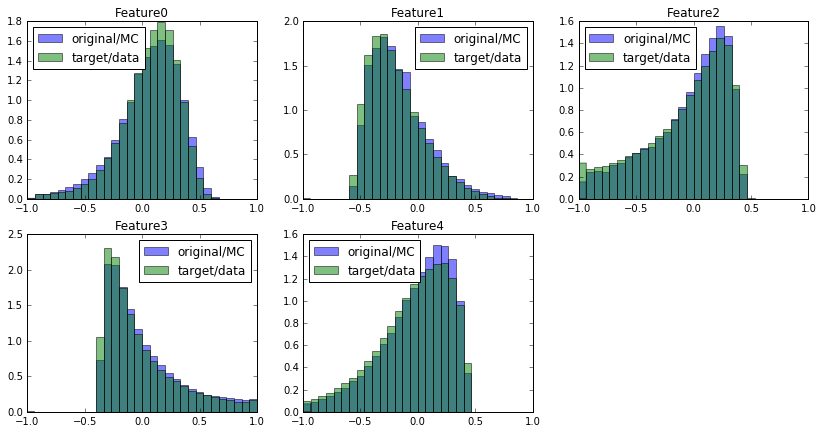

ROC AUC 0.602490565443


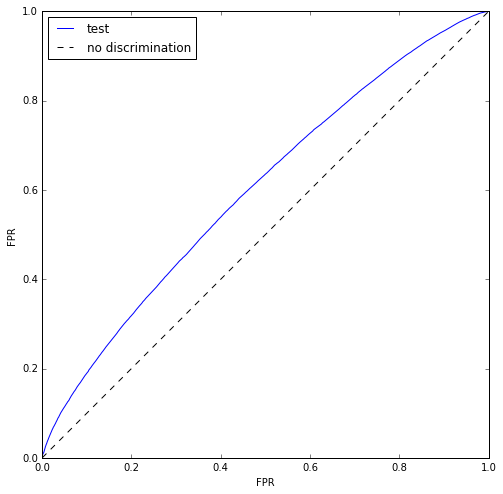

In [18]:
new_test_original_weights = weights_for_two_features('Feature1', 'Feature2', 10) 
check_discrimination(new_bdt_test_original_weights)

**Exercise #2.** Reweight distribution using BDT. Tune max_depth, n_estimators and maybe other parameters to achieve good reweighting rule. Use the code given above.

Compare results obtained from the both exercises.

In [19]:
for n in [10, 20, 50]:
    reweighter = GBReweighter(n_estimators=n, max_depth=2, learning_rate=0.4)
    reweighter.fit(train_original, train_target)
    new_bdt_test_original_weights = reweighter.predict_weights(test_original)
    roc = get_discrimination_roc(new_bdt_test_original_weights)
    print "n = {} ROC {}".format(n, roc)

n = 10 ROC 0.602490565443
n = 20 ROC 0.567467762743
n = 50 ROC 0.522295094148


In [20]:
for max_depth in [2, 3, 4, 5]:
    reweighter = GBReweighter(n_estimators=50, max_depth=max_depth, learning_rate=0.4)
    reweighter.fit(train_original, train_target)
    new_bdt_test_original_weights = reweighter.predict_weights(test_original)
    roc = get_discrimination_roc(new_bdt_test_original_weights)
    print "max_depth = {} ROC {}".format(max_depth, roc)

max_depth = 2 ROC 0.522295094148
max_depth = 3 ROC 0.512898800188
max_depth = 4 ROC 0.990317472024
max_depth = 5 ROC 0.988531063326


In [21]:
for min_samples_leaf in [100, 200, 300, 400]:
    reweighter = GBReweighter(n_estimators=50, max_depth=3, min_samples_leaf=min_samples_leaf, learning_rate=0.4)
    reweighter.fit(train_original, train_target)
    new_bdt_test_original_weights = reweighter.predict_weights(test_original)
    roc = get_discrimination_roc(new_bdt_test_original_weights)
    print "min_samples_leaf = {} ROC {}".format(min_samples_leaf, roc)

min_samples_leaf = 100 ROC 0.993198420416
min_samples_leaf = 200 ROC 0.512898800188
min_samples_leaf = 300 ROC 0.506214991731
min_samples_leaf = 400 ROC 0.512631291328


In [22]:
for subsample in [0.3, 0.5, 0.7]:
    reweighter = GBReweighter(n_estimators=50, 
                              max_depth=3, 
                              min_samples_leaf=300, 
                              gb_args={'subsample': subsample},
                              learning_rate=0.4)
    reweighter.fit(train_original, train_target)
    new_bdt_test_original_weights = reweighter.predict_weights(test_original)
    roc = get_discrimination_roc(new_bdt_test_original_weights)
    print "subsample = {} ROC {}".format(subsample, roc)

subsample = 0.3 ROC 0.519168714251
subsample = 0.5 ROC 0.529036326365
subsample = 0.7 ROC 0.510277598524


In [23]:
for n in [50, 60, 80]:
    reweighter = GBReweighter(n_estimators=n, 
                              max_depth=3, 
                              min_samples_leaf=300, 
                              learning_rate=0.3)
    reweighter.fit(train_original, train_target)
    new_bdt_test_original_weights = reweighter.predict_weights(test_original)
    roc = get_discrimination_roc(new_bdt_test_original_weights)
    print "n = {} ROC {}".format(n, roc)

n = 50 ROC 0.506415006784
n = 60 ROC 0.507448948213
n = 80 ROC 0.507451705381


In [24]:
reweighter = GBReweighter(n_estimators=50, 
                          max_depth=3, 
                          min_samples_leaf=300, 
                          learning_rate=0.3)
reweighter.fit(train_original, train_target)
new_bdt_test_original_weights = reweighter.predict_weights(test_original)

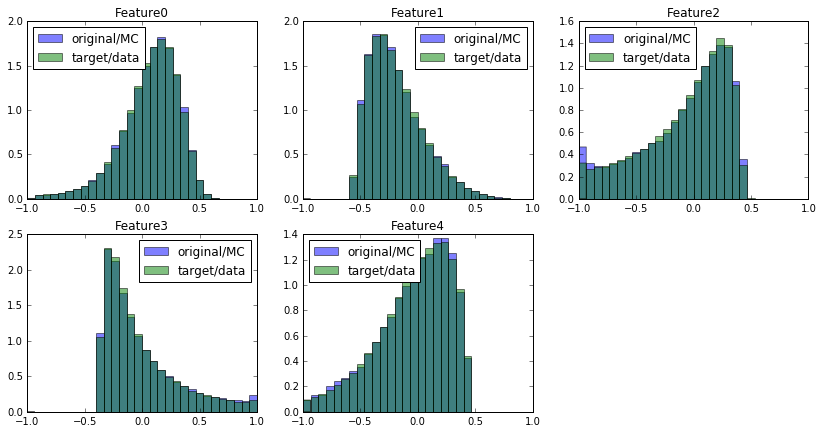

ROC AUC 0.506415006784


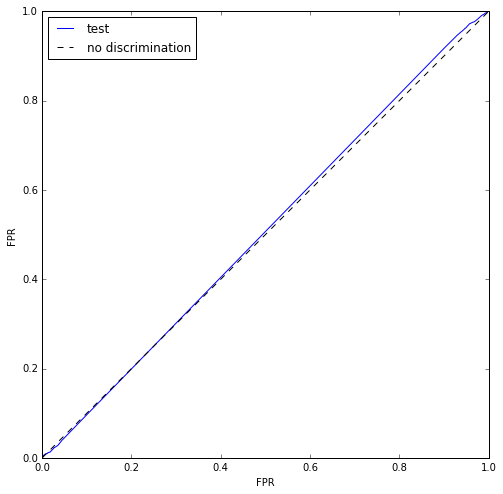

In [25]:
check_discrimination(new_bdt_test_original_weights)

Results:
* Most relevant feature for reweighting with bins is Feature1 number of bins 80
* Most relevant two features for reweighting with bins is Feature1 and Feature2 number of bins 10 * 10
* Reweight distribution using BDT gives much better results